# Study of [EPIC249624646](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=249624646)

For the star's properties, I have used those calculated in [this paper](https://arxiv.org/pdf/1901.03716.pdf).

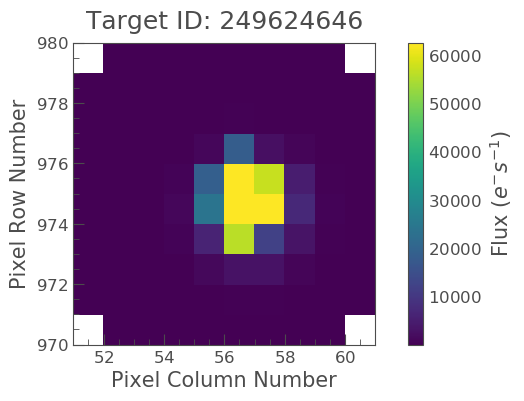

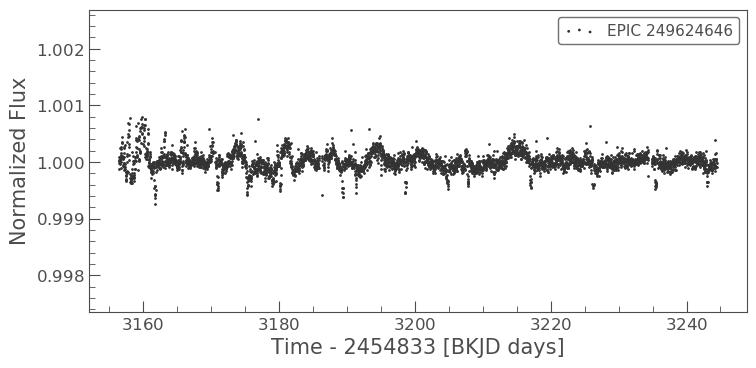

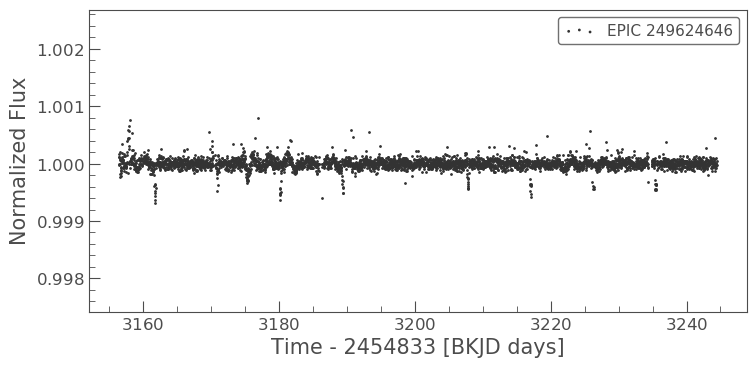

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '249624646'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans().remove_outliers()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=401, return_trend=True)
corr_lc_f.scatter()

In [2]:
corr_lc_f.time_format = 'bjd'

# Creating a file to store the data
f = open("249624646.txt", "w+")

for i in range(len(corr_lc_f.flux)):
    L = [str(corr_lc_f.time[i]+2454833), " ", str(corr_lc_f.flux[i]), " ", str(corr_lc_f.flux_err[i]), "\n"]
    f.writelines(L)
    
corr_lc_f.time_format = 'bkjd'

`period` contains 377785 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


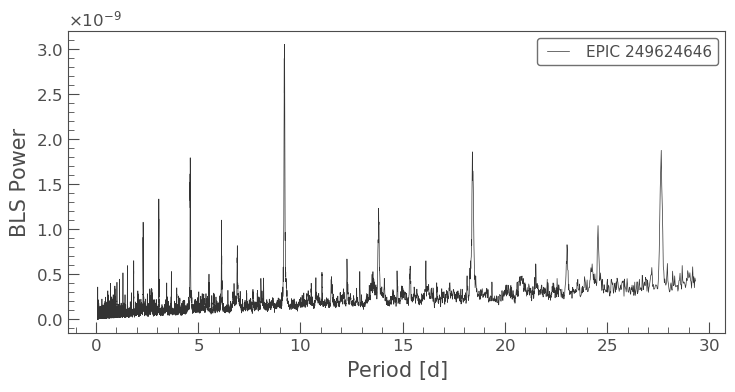

In [3]:
pg = corr_lc_f.to_periodogram("bls", frequency_factor=5, duration=0.05)
pg.plot();

(<Time object: scale='tdb' format='jd' value=2457997.7639234653>,
 <Quantity 9.22064973 d>)

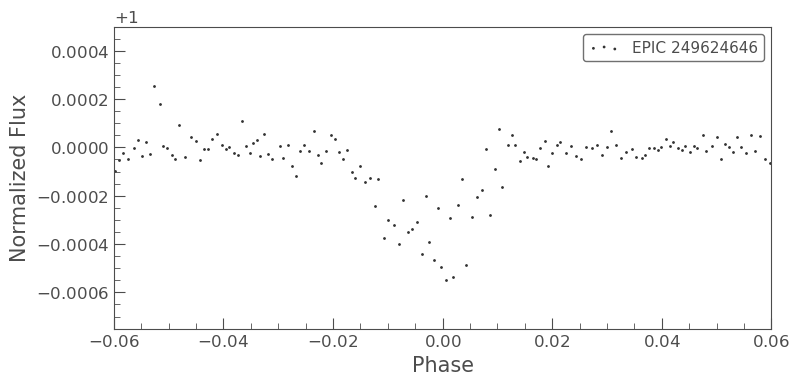

In [4]:
lc_transit = corr_lc_f.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power).bin(3)
lc_transit.scatter()
plt.xlim([-0.06, 0.06]);
plt.ylim([0.99925, 1.0005]);
pg.time_format = 'bjd'
pg.transit_time_at_max_power+corr_lc_f.astropy_time[0], pg.period_at_max_power,

In [5]:
import math

R_star = 1.337 # in sun's radius
R_star = R_star * 695510000 # in meter

Td_values = lc_transit.time[lc_transit.flux < 0.9998]
Td = Td_values[-1] - Td_values[0]

min_tr = lc_transit.flux[lc_transit.flux < 0.9998].mean()
R_planet = math.sqrt(1-min_tr)*R_star
R_planet = R_planet / R_star # in jupiter's radius

Td , R_planet

(0.34346280587688705, 0.01842366745369421)

In [7]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 1.093*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (Td*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b

(14.260640030716361, 85.9789434534118, 0.9999999998134678)

|      EPIC          |       249624646      |
|:------------------:|:--------------------:|
|   Planet's period  |      9.2144 days     |
|   Planet's radius  |0.296 Jupiter's radius|
| Transit's duration |      0.0221 days     |
|     Inclination    |    88.650°           |
|   Semi-major axis  |       0.2838 AU      |
|   Temperature      |       6137 K         |

## With batman:

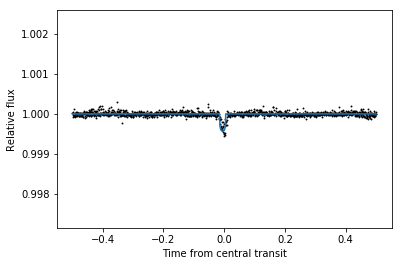

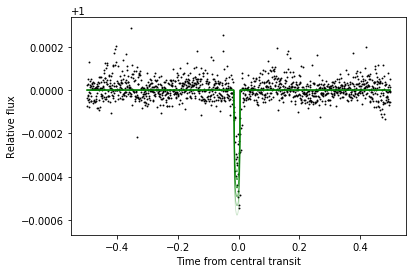

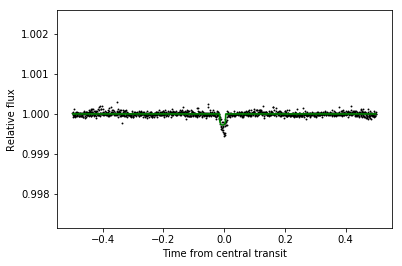

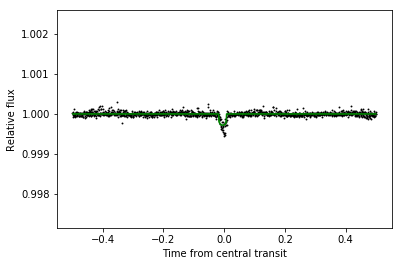

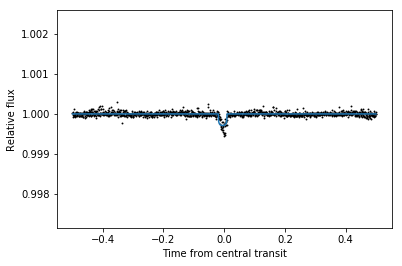

Planet's radius: 0.16961051239032915 [Jupiter radius]
Planet's semi-major axis: 0.05894372666716387 [AU]
Planet's inclination: 87.02222222222223 [degrees]


In [10]:
import batman

params = batman.TransitParams()
params.t0 = -0.005                      #time of inferior conjunction
params.per = abs(lc_transit[-1].phase - lc_transit[0].phase)                      #orbital period
params.rp = 0.0196                      #planet radius (in units of stellar radii)
params.a = 14.253                     #semi-major axis (in units of stellar radii)
params.inc = 88                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.30495, 0.3095]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lc_transit[0].phase, lc_transit[-1].phase, len(lc_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

#RADIUS

rp_min = params.rp-0.2*params.rp
rp_max = params.rp+0.2*params.rp
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(rp_min, rp_max, 10)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(r - ((rp_max+rp_min)/2))/((rp_max-rp_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.show()
pos_min = 0
for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1] and possible_radii[i][1]<possible_radii[pos_min][1]):
        pos_min = i
        
params.rp = possible_radii[pos_min][0]

#SEMI-MAJOR AXIS

a_min = params.a - 0.2*params.a
a_max = params.a + 0.2*params.a
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(a_min, a_max, 10)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(a - ((a_max+a_min)/2))/((a_max-a_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_axis.append([a,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1] and possible_axis[i][1]<possible_axis[pos_min][1]):
        pos_min = i

params.a = possible_axis[pos_min][0]

#INCLINATION

i_min = params.inc - 0.02*params.inc
i_max = params.inc + 0.02*params.inc
plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(i_min, i_max, 10)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.plot(t, new_flux, alpha = 1 - abs(i - ((i_max+i_min)/2))/((i_max-i_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lc_transit.flux[count]-f)
            count += 1
        possible_inc.append([i,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1] and possible_inc[i][1]<possible_inc[pos_min][1]):
        pos_min = i

params.i = possible_inc[pos_min][0]

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

print("Planet's radius: " + str(possible_radii[pos_min][0]/0.102719) + " [Jupiter radius]")
print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]/214.93946938362) + " [AU]")
print("Planet's inclination: " + str(possible_inc[pos_min][0]) + " [degrees]")

## Using ExoFAST:

Transit fit:  
Chi^2/dof = 3.7627364e-06  
Scaling errors by 0.0019399416  
RMS of residuals = 0.00012075230  

Combined fit:  
Chi^2 of Transit data = 0.017376393 (3955 data points)  
Chi^2 of Priors = 0.0017644124 (7 priors)  
Chi^2/dof = 8.6680747e-06   
  

| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 9.212785    |
| a      | Semi-Major Axis                   | AU      | 0.092458    |
| Rp     | Planet Radius                     | Rj      | 0.303408    |
| Teq    | Equilibrium Temperature           | K       | 1191.801535 |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.314521    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.305278    |
| i      | Inclination                       | degrees | 88.603637   |
| b      | Impact Parameter                  | none    | 0.340648    |
| delta  | Transit Depth                     | none    | 0.000481    |
| TFWHM  | FWHM Duration                     | days    | 0.197436    |
| tau    | Ingress/Egress Duration           | days    | 0.004904    |
| T14    | Total Duration                    | days    | 0.202340    |

## Second planet:

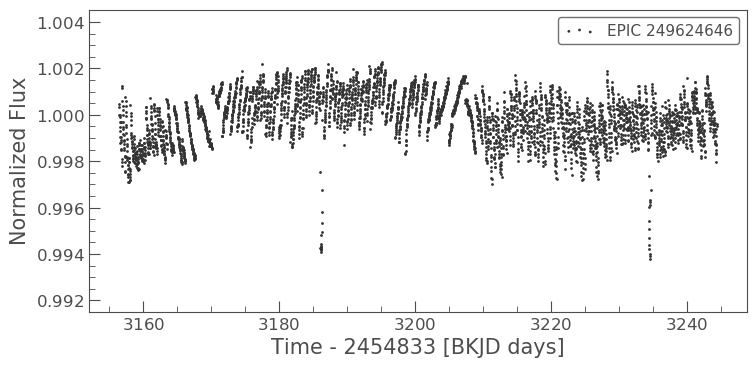

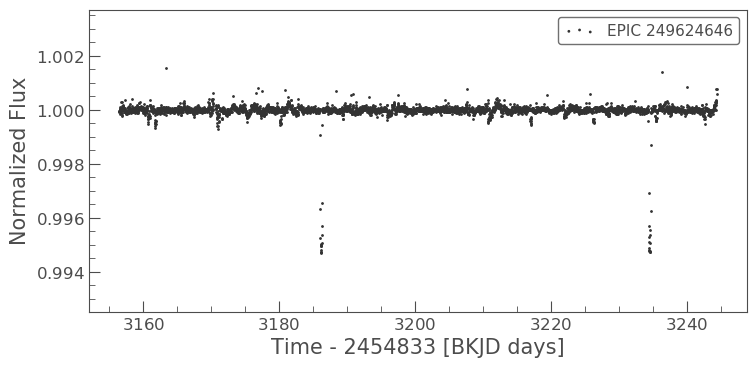

In [11]:
lcp = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lcp.scatter()
corr_lcp = lcp.to_corrector("sff").correct(windows=40)
corr_lcp_f, trend = corr_lcp.flatten(window_length=401, return_trend=True)
corr_lcp_f.scatter()

In [12]:
corr_lcp_f.time_format = 'bjd'

# Creating a file to store the data
f = open("249624646_2.txt", "w+")

for i in range(len(corr_lcp_f.flux)):
    L = [str(corr_lcp_f.time[i]+2454833), " ", str(corr_lcp_f.flux[i]), " ", str(corr_lcp_f.flux_err[i]), "\n"]
    f.writelines(L)
    
corr_lcp_f.time_format = 'bkjd'

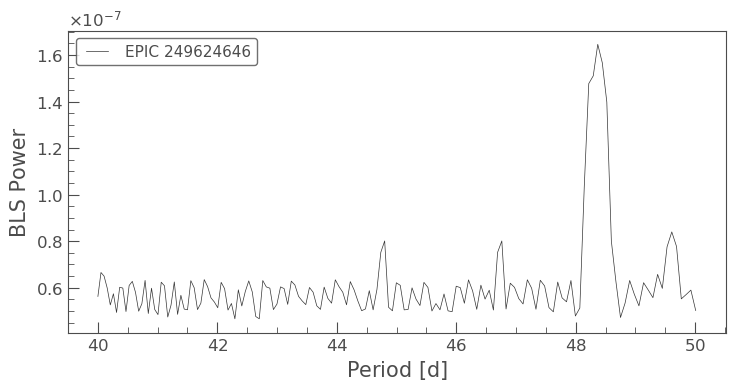

In [13]:
pg = corr_lcp_f.to_periodogram("bls", minimum_period=40, maximum_period=50, frequency_factor=5, duration=0.05)
pg.plot();

(<Time object: scale='tdb' format='jd' value=2458031.59921963>,
 <Quantity 48.36978531 d>)

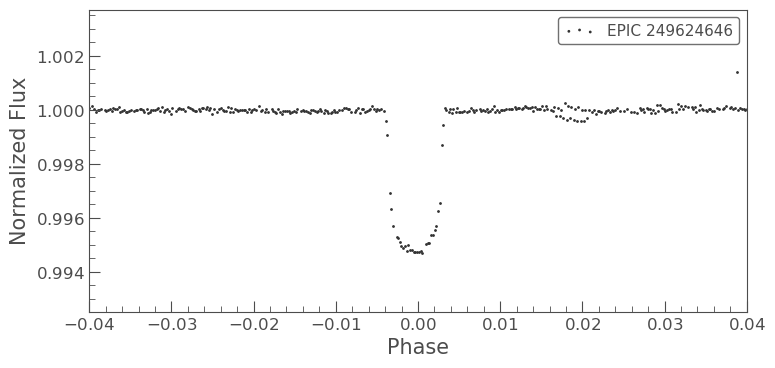

In [14]:
lcp_transit = corr_lcp_f.fold(pg.period_at_max_power.value, pg.transit_time_at_max_power)
lcp_transit.scatter()
plt.xlim([-0.04, 0.04]);
pg.transit_time_at_max_power+corr_lcp_f.astropy_time[0], pg.period_at_max_power,

In [15]:
import math

R_star_c = 1.337 # in sun's radius
R_star_c = R_star_c * 695510000 # in meter

Td_values = lcp_transit.time[lcp_transit.flux < 0.9995]
Td = Td_values[-1] - Td_values[0]

R_planet_c = math.sqrt(1-min(lcp_transit.flux))*R_star
R_planet_c = R_planet_c / R_star # in jupiter's radius

R_planet_c

0.07283281008452158

In [17]:
G = 6.67408 * 10**(-11)
P = pg.period_at_max_power.value*86400
M = 1.093*1.98847*10**30
a = (G*M*P**2/(2*math.pi)**2) ** (1./3)
i = math.acos(math.sqrt((R_star/a)**2 - (Td*math.pi/P)**2)) # in radians
b = a * math.cos(i)

a = a / R_star # astronomical unit
b = b / R_star
i = math.degrees(i)

a, i, b

(43.05405960785284, 88.66909339383614, 0.9999999996146095)

## With batman:

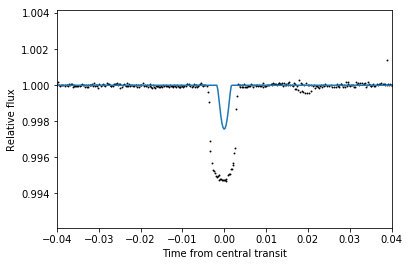

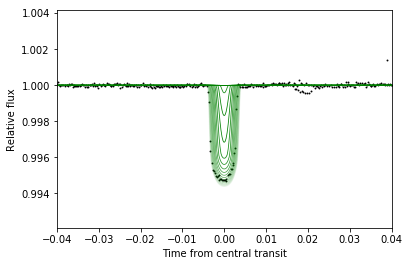

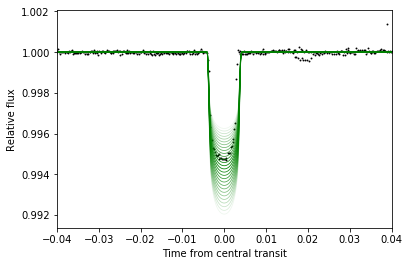

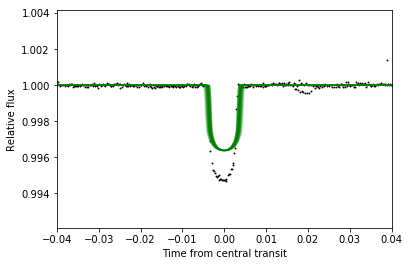

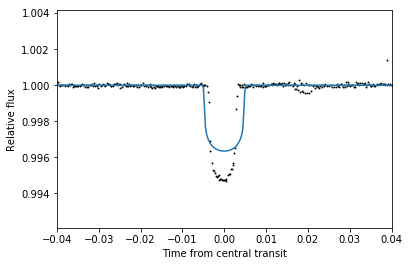

Planet's radius: 0.5451766469689152 [Jupiter radius]
Planet's semi-major axis: 0.14887912439612005 [AU]
Planet's inclination: 87.714 [degrees]


In [29]:
params = batman.TransitParams()
params.t0 = 0.000                    #time of inferior conjunction
params.per = abs(lcp_transit[-1].phase - lcp_transit[0].phase)                      #orbital period
params.rp = 0.07                      #planet radius (in units of stellar radii)
params.a = 40                     #semi-major axis (in units of stellar radii)
params.inc = 88.6                  #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.30495, 0.3095]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lcp_transit[0].phase, lcp_transit[-1].phase, len(lcp_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.xlim([-0.04, 0.04]);
plt.scatter(lcp_transit.time, lcp_transit.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.plot(t, flux)
plt.xlim([-0.04, 0.04]);
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

#INCLINATION

i_min = params.inc - 0.01*params.inc
i_max = params.inc + 0.01*params.inc
plt.scatter(lcp_transit.time, lcp_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
incl = np.linspace(i_min, i_max, 30)
possible_inc = []
for i in incl:
        params.inc = i                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.xlim([-0.04, 0.04]);
        plt.plot(t, new_flux, alpha = 1 - abs(i - ((i_max+i_min)/2))/((i_max-i_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcp_transit.flux[count]-f)
            count += 1
        possible_inc.append([i,diff])

plt.xlim([-0.04, 0.04]);
plt.show()
pos_min = 0
for i in range(0,len(possible_inc)-1):
    if (possible_inc[i][1]<possible_inc[i+1][1] and possible_inc[i][1]<possible_inc[pos_min][1]):
        pos_min = i

params.i = possible_inc[pos_min][0]

#RADIUS

rp_min = params.rp-0.2*params.rp
rp_max = params.rp+0.2*params.rp
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
radii = np.linspace(rp_min, rp_max, 30)
possible_radii = []
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)
        plt.xlim([-0.04, 0.04]);
        plt.plot(t, new_flux, alpha = 1 - abs(r - ((rp_max+rp_min)/2))/((rp_max-rp_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcp_transit.flux[count]-f)
            count += 1
        possible_radii.append([r,diff])

        
plt.scatter(lcp_transit.time, lcp_transit.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.show()
pos_min = 0
for i in range(0,len(possible_radii)-1):
    if (possible_radii[i][1]<possible_radii[i+1][1] and possible_radii[i][1]<possible_radii[pos_min][1]):
        pos_min = i
        
params.rp = possible_radii[pos_min][0]

#SEMI-MAJOR AXIS

a_min = params.a - 0.2*params.a
a_max = params.a + 0.2*params.a
plt.scatter(lcp_transit.time, lcp_transit.flux, s=.8, c='k')
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
axis = np.linspace(a_min, a_max, 30)
possible_axis = []
for a in axis:
        params.a = a                           #updates planet semi-major axis
        new_flux = m.light_curve(params)
        plt.xlim([-0.04, 0.04]);
        plt.plot(t, new_flux, alpha = 1 - abs(a - ((a_max+a_min)/2))/((a_max-a_min)/2), color='green', linewidth=0.8)
        diff = 0
        count = 0
        for f in new_flux:
            diff += abs(lcp_transit.flux[count]-f)
            count += 1
        possible_axis.append([a,diff])

plt.show()
pos_min = 0
for i in range(0,len(possible_axis)-1):
    if (possible_axis[i][1]<possible_axis[i+1][1] and possible_axis[i][1]<possible_axis[pos_min][1]):
        pos_min = i

params.a = possible_axis[pos_min][0]

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.xlim([-0.04, 0.04]);
plt.scatter(lcp_transit.time, lcp_transit.flux, s=.8, c='k')
plt.xlim([-0.04, 0.04]);
plt.plot(t, flux)
plt.xlim([-0.04, 0.04]);
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.xlim([-0.04, 0.04]);
plt.show()

print("Planet's radius: " + str(possible_radii[pos_min][0]/0.102719) + " [Jupiter radius]")
print("Planet's semi-major axis: " + str(possible_axis[pos_min][0]/214.93946938362) + " [AU]")
print("Planet's inclination: " + str(possible_inc[pos_min][0]) + " [degrees]")

### We have two planets!

## Using ExoFAST:

Transit fit:  
Chi^2/dof = 3.6860057e-06  
Scaling errors by 0.0019200560  
RMS of residuals = 0.00039747290  
  
Combined fit:  
Chi^2 of Transit data = 0.054347594 (4044 data points)  
Chi^2 of Priors = 0.026361365 (7 priors)  
Chi^2/dof = 2.3686875e-05    
    
  
| symbol | parameter                         | units   | value       |
|--------|-----------------------------------|---------|-------------|
| P      | Period                            | days    | 48.368825   |
| a      | Semi-Major Axis                   | AU      | 0.279292    |
| Rp     | Planet Radius                     | Rj      | 1.383365    |
| Teq    | Equilibrium Temperature           | K       | 685.334512  |
| u1     | Linear Limb-Darkening Coeff       | none    | 0.314216    |
| u2     | Quadratic Limb-Darkening Coeff    | none    | 0.304869    |
| i      | Inclination                       | degrees | 89.160489   |
| b      | Impact Parameter                  | none    | 0.619521    |
| delta  | Transit Depth                     | none    | 0.010017    |
| TFWHM  | FWHM Duration                     | days    | 0.284386    |
| tau    | Ingress/Egress Duration           | days    | 0.046683    |
| T14    | Total Duration                    | days    | 0.331069    |